# Diabetes Prediction using Logistic Regression

This notebook is a complete end-to-end machine learning project on the Diabetes dataset.  
The goal is to predict whether a person is diabetic (Outcome = 1) or not (Outcome = 0) using medical features such as Glucose, BloodPressure, BMI, Insulin, and Age.

## What I do in this project

- Load and explore the diabetes dataset.
- Clean medically invalid zero values (Glucose, BloodPressure, SkinThickness, Insulin, BMI).
- Analyze feature distributions, boxplots, and correlations.
- Split the data into train and test sets.
- Scale features using StandardScaler.
- Handle class imbalance with SMOTE on the training data.
- Train a Logistic Regression model.
- Evaluate the model using accuracy, confusion matrix, and classification report.

This notebook is mainly for learning and documenting what I have practiced in machine learning.


##  Loading Libraries and Dataset

In this section, I import the main Python libraries that I use throughout the notebook:

- **NumPy** and **Pandas** for numerical operations and data manipulation.
- **Matplotlib** and **Seaborn** for visualizations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Then I load the **Diabetes** dataset from `diabetes.csv` into a Pandas DataFrame and display the first few rows to get a quick look at the data structure and column names.


In [2]:
# Loading the Dataset

df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Inspecting the Dataset Structure

Before doing any modeling, I quickly inspect the structure of the dataset:

- `df.columns` shows all feature names: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, and the target `Outcome`.
- `df.dtypes` confirms that all features and the target are stored in numeric formats (integers or floats), which is convenient for machine learning models.
- `df.isnull().any()` checks for missing values. All columns return `False`, so there are **no NaN values** in this dataset.
- `df.shape` shows that the dataset contains 768 rows and 9 columns.

This step gives me confidence that the raw data is loaded correctly and there are no missing values to handle.

In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [6]:
df.shape

(768, 9)

# Exploratory Data Analysis – Correlations and Summary Statistics

To understand relationships between the features and the target `Outcome`, I compute the **correlation matrix** and visualize it using a Seaborn heatmap:

- `Glucose`, `BMI`, and `Age` show a relatively stronger positive correlation with `Outcome`, meaning higher values of these features are more associated with diabetes.
- `Pregnancies` also has a moderate positive correlation with `Outcome`, while some features such as `SkinThickness` and `BloodPressure` show weaker relationships.

Below the heatmap, `df.describe()` gives a numeric summary of each column (count, mean, standard deviation, minimum, maximum, and quartiles).  
This helps me understand the scale of each feature, detect possible outliers, and see that `Outcome` is imbalanced (more 0s than 1s).

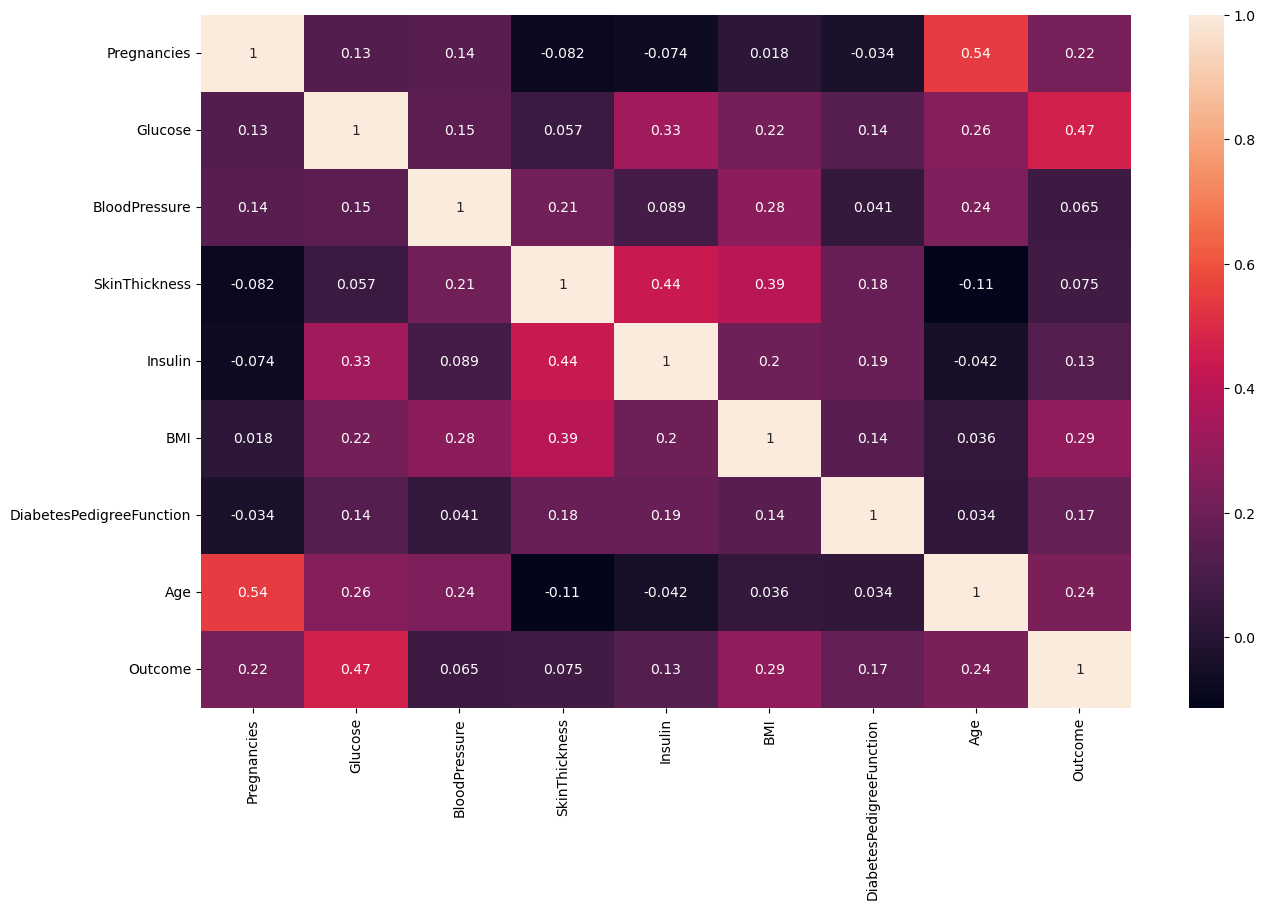

In [7]:
df.corr()
plt.figure(figsize=(15,9))
ax = sns.heatmap(df.corr(), annot=True)
plt.savefig("corr. coeff. Heatmap.png")
plt.show()

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Feature Distributions (Before Cleaning Zeros)

Here I plot the distribution of each numeric feature using histograms with KDE curves:

- **Glucose, BloodPressure, BMI** look roughly bell-shaped but show some skewness.
- **Insulin** and **SkinThickness** are highly skewed with many low values and a long tail.
- **Pregnancies, DiabetesPedigreeFunction, Age** are also right-skewed, meaning most patients are on the lower side with a few very high values.

These plots help me understand the data range, skewness, and presence of potential outliers before any cleaning or transformation. They also motivate later steps such as handling invalid zeros and using techniques like scaling and outlier treatment.


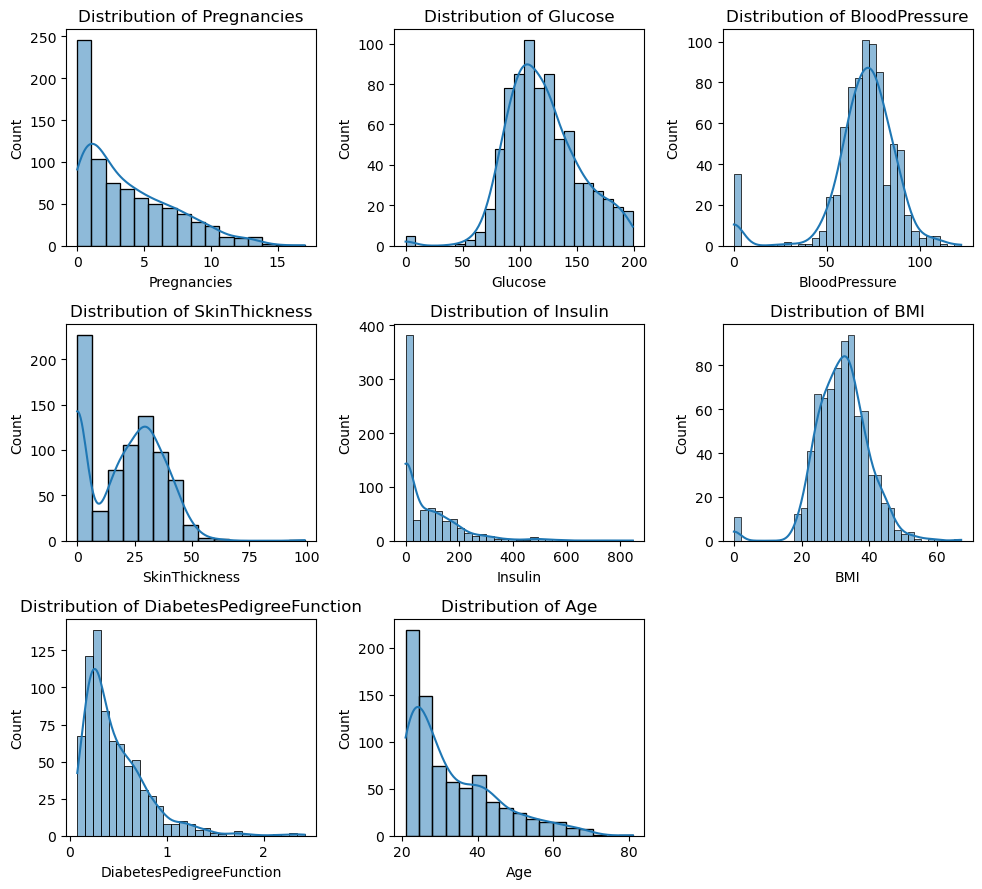

In [9]:
cols = df.drop("Outcome", axis=1).columns  # exclude target

plt.figure(figsize=(10, 9))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title('Distribution of '+ col)
    plt.tight_layout()

plt.show()

# Handling Medically Invalid Zero Values

In the original dataset, some medical features contain many values equal to 0:

- `Glucose`
- `BloodPressure`
- `SkinThickness`
- `Insulin`
- `BMI`

For a real patient, these measurements cannot realistically be exactly zero, so I treat these zeros as **missing values**.

To fix this:

1. I create a list `cols_with_zero` with the medically invalid columns.
2. I temporarily replace 0 with `NaN` to mark them as missing.
3. For each column in this list, I fill the missing values with the **median** of that column.

After this step, the distributions of these features look more realistic and do not contain impossible zero values, which helps the model learn better patterns for diabetes prediction.


In [10]:
cols_with_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

df[cols_with_zero] = df[cols_with_zero].replace(0,np.nan)

for col in cols_with_zero:
    df[col] = df[col].fillna(df[col].median())

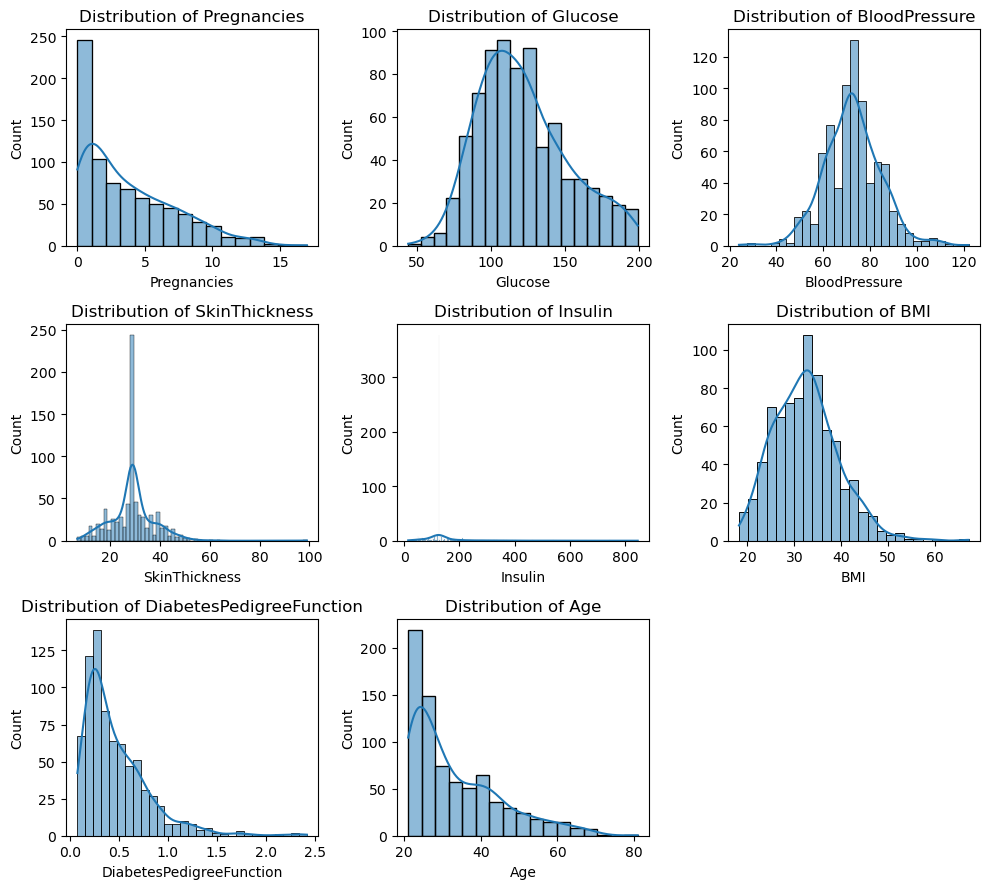

In [11]:
cols = df.drop("Outcome", axis=1).columns

plt.figure(figsize=(10, 9))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title('Distribution of '+ col)
    plt.tight_layout()

plt.show()

# Detecting and Treating Outliers with IQR

To understand the presence of outliers in each feature, I first plot **boxplots** for all numeric columns (excluding `Outcome`):

- The circles above and below the boxes represent potential outliers.
- Features like `Insulin`, `SkinThickness`, and `BMI` show many extreme values.

To reduce the impact of these extreme points, I define an `iqr_capping` function:

1. For each column, I compute:
   - Q1 (25th percentile) and Q3 (75th percentile).
   - IQR = Q3 − Q1.
2. I calculate the lower and upper limits as:
   - Lower = Q1 − 1.5 × IQR  
   - Upper = Q3 + 1.5 × IQR
3. Values outside this range are **clipped** to the nearest boundary (lower or upper).

This keeps the overall distribution but prevents very extreme values from dominating the model training.


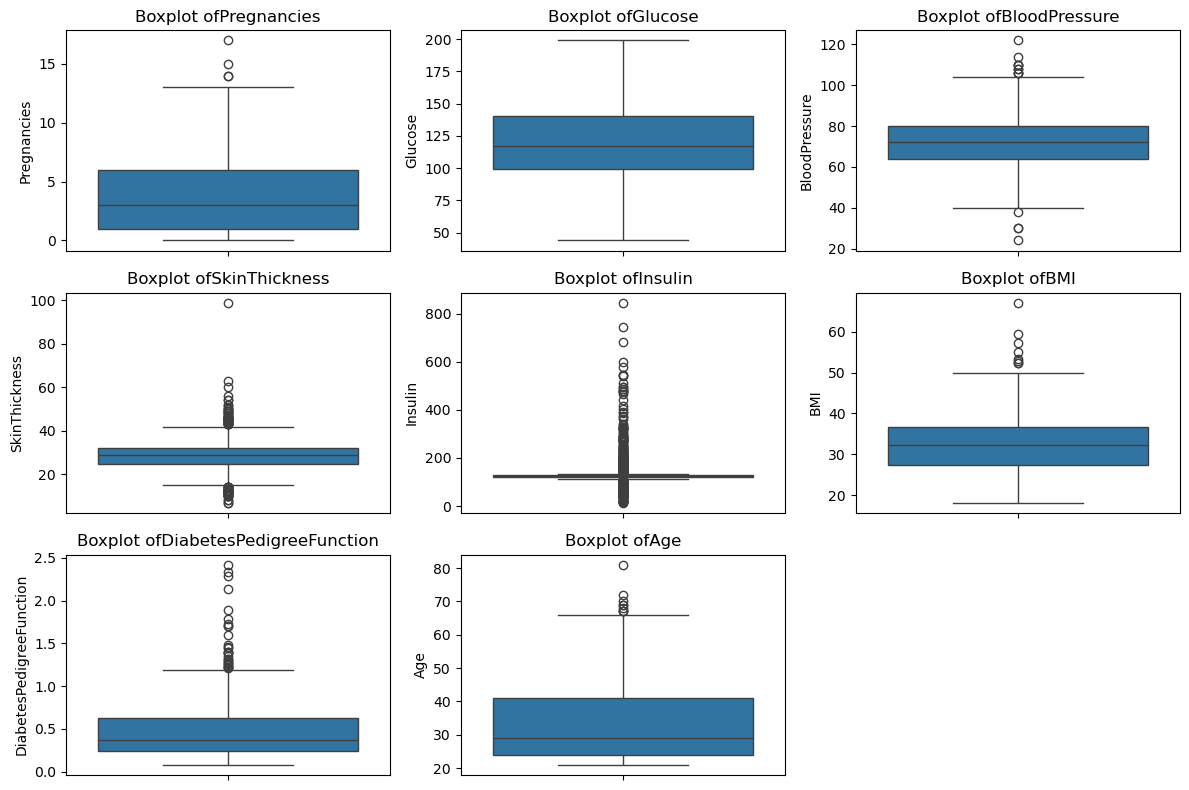

In [12]:
cols = df.drop("Outcome", axis=1).columns

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title('Boxplot of' + col)
    plt.tight_layout()

plt.show()

In [13]:
def iqr_capping(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df[col] = df[col].clip(lower, upper)
    return df

cols_to_cap = df.drop("Outcome", axis=1).columns
df = iqr_capping(df, cols_to_cap)

# Boxplots After IQR Capping

After applying the IQR-based capping function, I re-plot the boxplots for all features:

- The overall **spread** of each feature is preserved, but the extreme outliers have been clipped to reasonable upper and lower bounds.
- The whiskers of the boxplots are now shorter, especially for features like **Insulin**, **SkinThickness**, and **BMI**, showing that very extreme values have been reduced.
- This makes the dataset more robust for model training, because no single extreme value can dominate the learning process.

From this point on, I use the IQR-capped DataFrame as the cleaned version of the data for splitting, scaling, SMOTE, and model training.


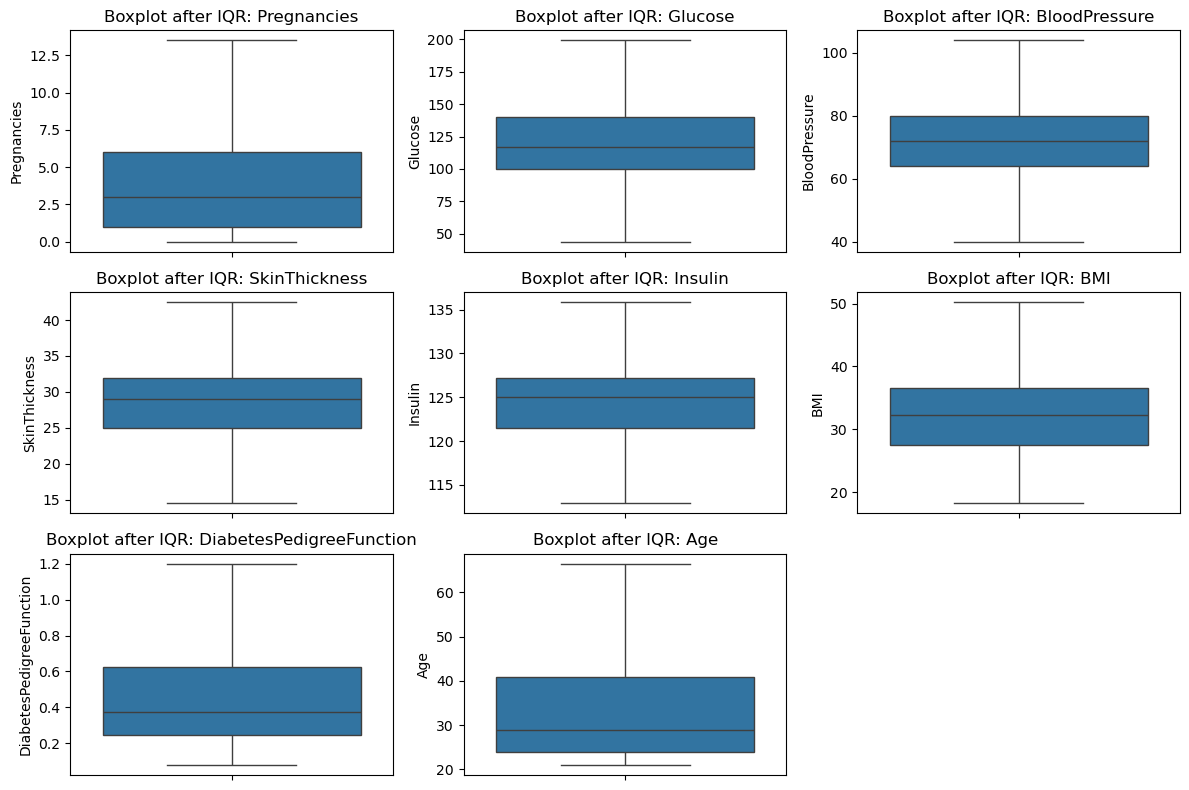

In [14]:
cols = df.drop("Outcome", axis=1).columns

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title('Boxplot after IQR: '+ col)
    plt.tight_layout()

plt.show()

In [15]:
df.shape

(768, 9)

# Train–Test Split, Scaling and SMOTE

Now I prepare the data for modeling:

1. **Train–Test Split**
   - I split the cleaned DataFrame into features `X` and target `y = df['Outcome']`.
   - Then I use `train_test_split` with `test_size = 0.2` and `random_state = 42`.
   - This gives me `X_train, X_test, y_train, y_test`, where the test set is kept aside only for final evaluation.
   - The value counts show that the target is imbalanced: more class 0 (non-diabetic) than class 1 (diabetic).

2. **Feature Scaling**
   - I create a `StandardScaler()` and **fit it only on `X_train`**.
   - `X_train_scaled = scaler.fit_transform(X_train)`
   - `X_test_scaled = scaler.transform(X_test)`
   - This avoids data leakage, because information from the test set is not used when computing the scaling parameters.

3. **Handling Class Imbalance with SMOTE**
   - I apply `SMOTE(random_state=42)` on the **scaled training data only**:
     - `X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)`
   - After SMOTE, the class distribution becomes perfectly balanced (401 samples of class 0 and 401 of class 1), which helps the model learn both classes more fairly.


In [16]:
x = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [17]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [20]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

In [21]:
y_train_smote.value_counts()

Outcome
0    401
1    401
Name: count, dtype: int64

#Training and Evaluating the Logistic Regression Model

### Model Training

I use **Logistic Regression** as my classification algorithm:

- I create the model with `lr = LogisticRegression()`.
- The model is trained on the **balanced and scaled** training data:  
  `lr.fit(X_train_smote, y_train_smote)`
- Because SMOTE has balanced the classes (401 vs 401), the model can learn patterns for both diabetic and non-diabetic patients more fairly.

### Making Predictions

- After training, I use the model to predict on the **scaled test set**:  
  `y_pred = lr.predict(X_test_scaled)`
- The test set was never used during training, scaling, or SMOTE, so this gives an honest estimate of how the model performs on unseen data.

### Evaluation Metrics

Using `accuracy_score`, `confusion_matrix`, and `classification_report`:

- **Accuracy** ≈ 0.7077 (around 71% of test samples are predicted correctly).
- The **confusion matrix** shows the counts of:
  - True Negatives (correctly predicted non-diabetic)
  - False Positives (predicted diabetic but actually non-diabetic)
  - False Negatives (missed diabetic cases)
  - True Positives (correctly predicted diabetic)
- The **classification report** provides precision, recall, and F1-score for each class:
  - Class 0 (non-diabetic)
  - Class 1 (diabetic)
- These metrics help me understand not only overall accuracy, but also how well the model balances between catching diabetic patients and avoiding false alarms.


In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_smote, y_train_smote)

LogisticRegression()

In [23]:
y_pred = lr.predict(x_test_scaled)
y_pred

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0])

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*50)

print('\n',"Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*50)

print('\n',"Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7077922077922078
--------------------------------------------------

 Confusion Matrix:
 [[68 31]
 [14 41]]
--------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75        99
           1       0.57      0.75      0.65        55

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.71       154



# Saving the Model and Scaler with Pickle

To reuse the trained model later (for example, in a separate script, API, or web app), I save:

- The **Logistic Regression model** to `diabetes_logistic_model.pkl`.
- The **StandardScaler** to `diabetes_scaler.pkl`.

These pickle files allow me to load the exact same model and preprocessing steps without retraining.


In [25]:
import pickle

# Save trained model
with open("diabetes_logistic_model.pkl", "wb") as f:
    pickle.dump(lr, f)

print("Model saved as diabetes_logistic_model.pkl")


Model saved as diabetes_logistic_model.pkl


In [26]:
with open("diabetes_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved as diabetes_scaler.pkl")

Scaler saved as diabetes_scaler.pkl
